# Univariate time series classification with sktime

In this notebook, we will use sktime for univariate time series classification. Here, we have a single time series variable and an associated label for multiple instances. The goal is to find a classifier that can learn the relationship between time series and label and accurately predict the label of new series.

When you have multiple time series variables and want to learn the relationship between them and a label, you can take a look at our [multivariate time series classification notebook](https://github.com/alan-turing-institute/sktime/blob/main/examples/03_classification_multivariate.ipynb).

Source: https://www.sktime.org/en/latest/examples/02_classification_univariate.html

### You may need to uncomment and run below

In [28]:
# !pip install hcrystalball
# !pip install catch22
# !pip install --upgrade tsfresh
# !pip install tbats

## Preliminaries

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope

## Load data

In this notebook, we use the [arrow head problem](https://timeseriesclassification.com/description.php?Dataset=ArrowHead).

The arrowhead dataset consists of outlines of the images of arrow heads. The classification of projectile points is an important topic in anthropology. The classes are based on shape distinctions such as the presence and location of a notch in the arrow.

<img src="./img/arrow-heads.png" width="200" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the **angle-based method** as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="300" alt="from shapes to time series">

### Data representation
Throughout sktime, the expected data format is a `pd.DataFrame`, but in a slightly unusual format. A **single column** can contain not only primitives (floats, integers or strings), but also entire time series in form of a `pd.Series` or `np.array`.

For more details on our choice of data container, see this [wiki entry](https://github.com/alan-turing-institute/sktime/wiki/Time-series-data-container).

In [30]:
# function to load the dataset
X, y = load_arrow_head(return_X_y=True)
# sklearns randomized TTSplit
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(158, 1) (158,) (53, 1) (53,)


Again we are using non temporal train test split

In [31]:
# univariate time series input data
X_train.head()

,dim_0
156,0 -1.9096 1 -1.9089 2 -1.8936 3 ...
60,0 -1.9674 1 -1.9672 2 -1.9512 3 ...
101,0 -1.7646 1 -1.7415 2 -1.7190 3 ...
23,0 -2.1597 1 -2.1756 2 -2.1656 3 ...
95,0 -1.8284 1 -1.8393 2 -1.8025 3 ...


In [32]:
# examine y_train counts
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1' '2'] [57 50 51]


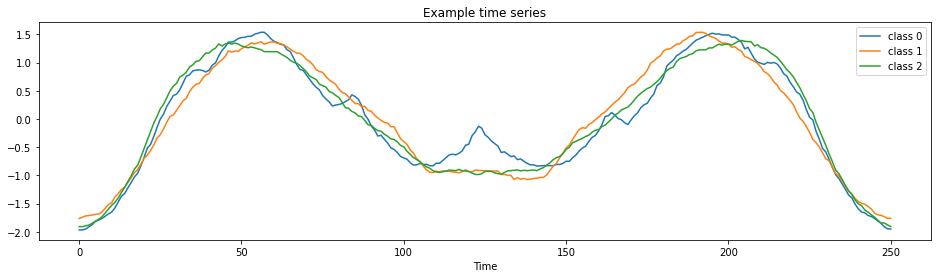

In [33]:
# plot one observation for each label class as an example
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time");

## Why not just use scikit-learn?

We can still use scikit-learn, but using scikit-learn comes with some implicit modelling choices.

### Reduction: from time-series classification to tabular classification

To use scikit-learn, we have to convert the data into the required tabular format. There are different ways we can do that:

#### Treating time points as separate features (tabularisation)
Alternatively, we could bin and aggregate observations in time bins of different length.

In [34]:
from sklearn.ensemble import RandomForestClassifier

from sktime.utils.data_processing import from_nested_to_2d_array

# use sktime processing  function
X_train_tab = from_nested_to_2d_array(X_train)
X_test_tab = from_nested_to_2d_array(X_test)

X_train_tab.head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__241,dim_0__242,dim_0__243,dim_0__244,dim_0__245,dim_0__246,dim_0__247,dim_0__248,dim_0__249,dim_0__250
156,-1.9096,-1.9089,-1.8936,-1.8819,-1.8496,-1.8146,-1.7775,-1.7361,-1.6697,-1.5965,...,-1.5373,-1.6144,-1.6508,-1.6996,-1.7402,-1.7951,-1.8455,-1.8453,-1.8787,-1.9091
60,-1.9674,-1.9672,-1.9512,-1.9138,-1.8754,-1.8163,-1.7921,-1.7639,-1.7257,-1.6843,...,-1.6493,-1.6650,-1.7102,-1.7297,-1.7641,-1.8069,-1.8527,-1.9121,-1.9486,-1.9507
101,-1.7646,-1.7415,-1.7190,-1.7129,-1.7023,-1.6918,-1.6858,-1.6503,-1.5869,-1.5185,...,-1.4938,-1.5106,-1.5516,-1.5954,-1.6723,-1.6993,-1.7086,-1.7350,-1.7603,-1.7617
23,-2.1597,-2.1756,-2.1656,-2.1010,-2.0227,-2.0029,-1.9155,-1.8727,-1.8772,-1.8200,...,-1.4652,-1.5956,-1.6959,-1.7689,-1.8850,-1.9688,-2.0088,-2.0832,-2.1211,-2.0965
95,-1.8284,-1.8393,-1.8025,-1.8020,-1.8287,-1.8259,-1.7783,-1.7323,-1.6846,-1.6698,...,-1.4939,-1.5367,-1.6354,-1.6602,-1.7071,-1.7607,-1.7717,-1.8214,-1.8265,-1.8344


#### Get a baseline model
DummyClassifier is a classifier that makes predictions using simple rules.

This classifier is useful as a simple baseline to compare with other (real) classifiers. Do not use it for real problems.

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

#### Accuracy using Dummy Classifier with tabularized data

In [35]:
from sklearn.dummy import DummyClassifier

classifier = DummyClassifier(strategy="prior")
classifier.fit(X_train_tab, y_train)
classifier.score(X_test_tab, y_test)

0.4528301886792453

#### Accuracy using Random Forest with tabularized data

In [36]:
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=21)
classifier.fit(X_train_tab, y_train)
y_pred = classifier.predict(X_test_tab)
accuracy_score(y_test, y_pred)

0.8490566037735849

In [37]:
from sklearn.pipeline import make_pipeline

# with sktime, we can write this as a pipeline
from sktime.transformations.panel.reduce import Tabularizer

classifier = make_pipeline(Tabularizer(), RandomForestClassifier(random_state=21))


In [38]:
# We go back to using X train and y train
X_train.head()

,dim_0
156,0 -1.9096 1 -1.9089 2 -1.8936 3 ...
60,0 -1.9674 1 -1.9672 2 -1.9512 3 ...
101,0 -1.7646 1 -1.7415 2 -1.7190 3 ...
23,0 -2.1597 1 -2.1756 2 -2.1656 3 ...
95,0 -1.8284 1 -1.8393 2 -1.8025 3 ...


#### Accuracy using a pipeline that incorporates Random Forest and tabularization

In [39]:
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.8490566037735849

What's the implicit modelling choice here?

> We treat each observation as a separate feature and thus ignore they are ordered in time. A tabular algorithm **cannot** make use of the fact that features are ordered in time, i.e. if we changed the order of the features, the fitted model and predictions wouldn't change. Sometimes this works well, sometimes it doesn't.

### Feature extraction

Another modelling choice: we could extract features from the time series and then use the features to fit our tabular classifier. Here we use [tsfresh](https://tsfresh.readthedocs.io) for automatic feature extraction.

[List](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) of tsfresh features.

In [40]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = transformer.fit_transform(X_train)
extracted_features.head()

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


,dim_0__sum_values,dim_0__median,dim_0__mean,dim_0__length,dim_0__standard_deviation,dim_0__variance,dim_0__maximum,dim_0__minimum
0,-0.000443,0.042103,-1.764940e-06,251.0,0.998006,0.996016,1.3932,-1.9096
1,0.000308,-0.012606,1.227092e-06,251.0,0.998003,0.996010,1.5382,-1.9674
2,-0.000141,0.032475,-5.617530e-07,251.0,0.998009,0.996022,1.5372,-1.7646
3,-0.000061,0.008013,-2.430279e-07,251.0,0.998005,0.996013,2.5540,-2.1756
4,-0.000167,0.009969,-6.653386e-07,251.0,0.998008,0.996021,1.5899,-1.8393


#### Using a pipeline to extract features (TSFresh) and fit random forest (sklearn)

In [41]:
classifier = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False), RandomForestClassifier()
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


0.8113207547169812

What's the implicit modelling choice here?

> Instead of working in the domain of the time series, we extract features from time series and choose to work in the domain of the features. Again, **sometimes this works well, sometimes it doesn't.** The main difficulty is finding discriminative features for the classification problem.


## Time series classification with sktime
sktime has a number of specialised time series algorithms.

### Time series forest
Time series forest is a modification of the random forest algorithm to the time series setting:

1. Split the series into multiple random intervals, with random start positions and random lengths
2. Extract features (mean, standard deviation and slope) from each interval, into a single feature vector
3. Train a decision tree on the extracted features,
4. Ensemble steps 1 - 3 for multiple trees

New series are classified according to a majority vote of all the trees in the forest.


For more details, take a look at the [paper](https://www.sciencedirect.com/science/article/pii/S0020025513001473).

In sktime, we can write:

In [42]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor

steps = [
    (
        "extract",
        RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        ),
    ),
    ("clf", DecisionTreeClassifier()),
]
time_series_tree = Pipeline(steps)

#### Accuracy of single tree using train/test
We can directly fit and evaluate the single time series tree (which is simply a pipeline).

In [43]:
time_series_tree.fit(X_train, y_train)
time_series_tree.score(X_test, y_test)

0.7169811320754716

For time series forest, we can simply use the single tree as the base estimator in the forest ensemble.

In [44]:
from sktime.classification import compose

In [45]:
tsf = compose.TimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=100,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=1,
    n_jobs=-1,
)

#### Accuracy of TSF using out-of-bag score:

In [46]:
tsf.fit(X_train, y_train)

if tsf.oob_score:
    print(tsf.oob_score_)

0.8670886075949367


#### Accuracy of TSF using train/test

In [47]:
tsf = compose.TimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.7924528301886793

### Feature importance

We can also obtain feature importances for the different features and intervals that the algorithms looked at and plot them in a feature importance graph over time.

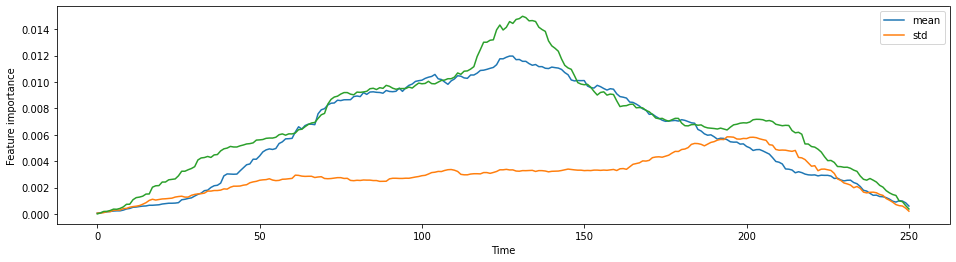

In [48]:
fi = tsf.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Feature importance");

#### More about feature importances

The feature importances method is based on the example showcased in [this paper](https://arxiv.org/abs/1302.2277).

In addition to the feature importances method [available in scikit-learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html), our method collects the feature importances values from each estimator for their respective intervals, calculates the **sum of feature importances values** on each timepoint, and **normalises** the values first by the number of estimators and then by the number of intervals.

As a result, the temporal importance curves can be plotted, as shown in the previous example.

Please note that this method currently supports only one particular
structure of the TSF, where RandomIntervalFeatureExtractor() is used in the pipeline, or simply the default TimeSeriesForestClassifier() setting. For instance, two possible approaches could be:

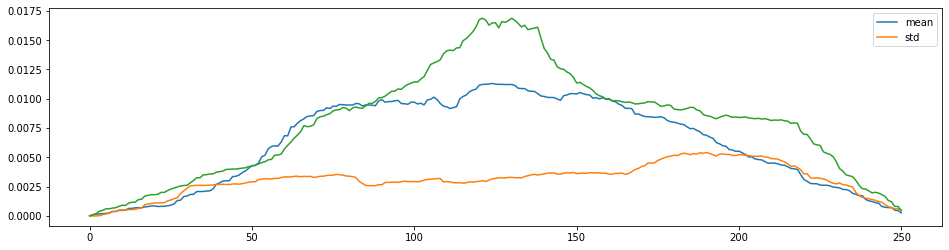

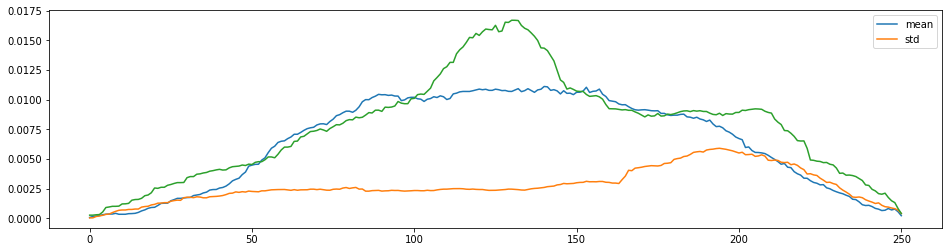

In [49]:
# Method 1: Default time-series forest classifier 
tsf1 = compose.TimeSeriesForestClassifier()
tsf1.fit(X_train, y_train)
fi1 = tsf1.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi1.plot(ax=ax)

# Method 2: Pipeline
features = [np.mean, np.std, _slope]
steps = [
    ("transform", RandomIntervalFeatureExtractor(features=features)),
    ("clf", DecisionTreeClassifier()),
]
base_estimator = Pipeline(steps)
tsf2 = compose.TimeSeriesForestClassifier(estimator=base_estimator)
tsf2.fit(X_train, y_train)
fi2 = tsf2.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
fi2.plot(ax=ax);

### RISE

Another popular variant of time series forest is the so-called Random Interval Spectral Ensemble (RISE), which makes use of several series-to-series feature extraction transformers, including:

* Fitted auto-regressive coefficients,
* Estimated autocorrelation coefficients,
* Power spectrum coefficients.

This is a frequency basd classifier that differs from Time Series Forest in two ways:

* Uses a single time series interval per tree
* Uses spectral features extracted from the series, instead of summary statistics

#### Spectral Analysis

Spectral analysis is a technique that allows us to discover underlying periodicities. In order to perform spectral analysis, we must transform data from time domain to the frequency domain.
The covariance of the time seires can be represented by a function known as the spectral density. Here we can use the periodogram to estimate the sepectral density

#### The RISE algorithm

1. Select random interval of a series, for the first tree, use the whole series
2. For the same interval on each sereis, apply the series-to-series feature extraction transformers (above)
3. Form a new training set by concatenating the extracted features
4. Train a decision tree classifier
5. Ensembe 1-4



In [55]:
from sktime.classification.interval_based import RandomIntervalSpectralForest

rise = RandomIntervalSpectralForest(n_estimators=10, acf_lag=24)
rise.fit(X_train, y_train)
rise.score(X_test, y_test)

0.8113207547169812

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

In [57]:
print( confusion_matrix(y_train, rise.predict(X_train)) )
print( classification_report(y_train, rise.predict(X_train)) )

[[57  0  0]
 [ 0 50  0]
 [ 0  0 51]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        51

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158



In [58]:
print( confusion_matrix(y_test, rise.predict(X_test)) )
print( classification_report(y_test, rise.predict(X_test)) )

[[22  2  0]
 [ 4 11  0]
 [ 0  4 10]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        24
           1       0.65      0.73      0.69        15
           2       1.00      0.71      0.83        14

    accuracy                           0.81        53
   macro avg       0.83      0.79      0.80        53
weighted avg       0.83      0.81      0.81        53



In [54]:
from sktime.utils import all_estimators

all_estimators(estimator_types="classifier")

[('BOSSEnsemble', sktime.classification.dictionary_based._boss.BOSSEnsemble),
 ('ColumnEnsembleClassifier',
  sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier),
 ('ContractableBOSS',
  sktime.classification.dictionary_based._cboss.ContractableBOSS),
 ('ElasticEnsemble',
  sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble),
 ('HIVECOTEV1', sktime.classification.hybrid._hivecote_v1.HIVECOTEV1),
 ('IndividualBOSS',
  sktime.classification.dictionary_based._boss.IndividualBOSS),
 ('IndividualTDE', sktime.classification.dictionary_based._tde.IndividualTDE),
 ('KNeighborsTimeSeriesClassifier',
  sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier),
 ('MUSE', sktime.classification.dictionary_based._muse.MUSE),
 ('MrSEQLClassifier',
  sktime.classification.shapelet_based.mrseql.mrseql.MrSEQLClassifier),
 ('ProximityForest',
  sktime.classification.distance_based._proximity_forest.ProximityForest),
 ('ProximitySt